In [1]:
#Import necessary libraries
import uuid
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import  Precision, Recall
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Setup the paths
POS_PATH = os.path.join('/content/data', 'positive')
NEG_PATH = os.path.join('/content/data', 'negative')
ANC_PATH = os.path.join('/content/data', 'anchor')

In [4]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [5]:
# Use http://vis-www.cs.umass.edu/lfw/ to get negative images

In [7]:
# Uncompress Tar GZ labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [9]:
# Move LFW Images to the data/negative folder
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', directory)):
    OLD_PATH = os.path.join('lfw', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(OLD_PATH, NEW_PATH)

In [12]:
#Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()

  # Cut down frame to 250x250px
  frame = frame[120:120250, 200:200+250, :]

  # Collect anchors
  if cv2.waitKey(1) & 0XFF == ord('a'):
      # Create the unique file path
      img_name = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
      # Write out anchor image
      cv2.imwrite(img_name, frame)

  #Collect positives
  if cv2.waitKey(1) & 0XFF == ord('p'):
    # Create the unique file path
      img_name = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
      # Write out positive image
      cv2.imwrite(img_name, frame)

  # Show image back to screen
  cv2.imshow('Image Collection', frame)

  # Exit the loop
  if cv2.waitkey(1) & 0XFF == ord('q'):
    break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [14]:
def preprocess(file_path):
  # Read in image from file_path
  byte_img = tf.io.read_file(file_path)
  # Load in the image
  img = tf.io.decode_jpeg(byte_img)

  # Preprocessing steps - resizing the image to the 100x100x3
  img = tf.image.resize(img, (105,105))
  # Scale image to be between 0 and 1
  img = img/255.0

  # Return preprocessed image
  return img

In [15]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
example = samples.next()

In [19]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*example)

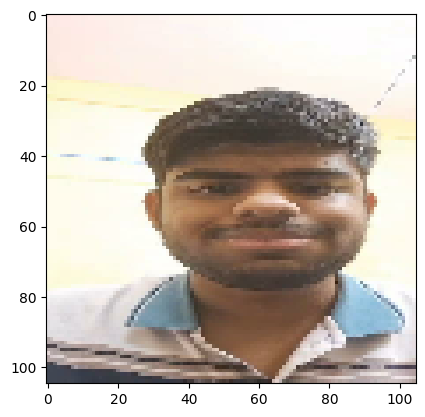

In [21]:
plt.imshow(res[1])

In [22]:
res[2]

1.0

In [23]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [24]:
samples = data.as_numpy_iterator()

In [25]:
example = samples.next()

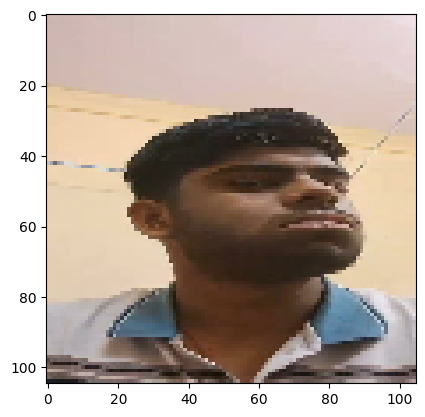

In [26]:
plt.imshow(example[0])

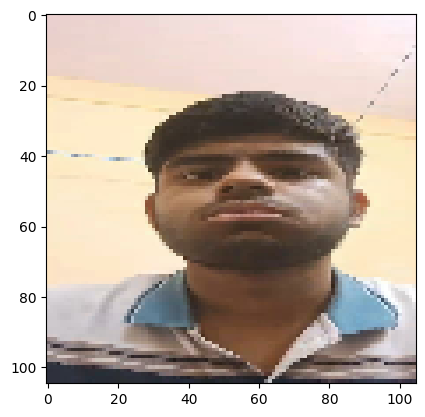

In [27]:
plt.imshow(example[1])

In [28]:
example[2]

1.0

In [29]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [31]:
def make_embedding():
  inp = Input(shape=(105,105,3), name='input_image')

  # First block
  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  #Second block
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  # Third block
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  # Final block
  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [32]:
model = make_embedding()

In [33]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [34]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [35]:
def make_Siamese_Model():

    embedding = make_embedding()
    # Handle inputs
    input_image = Input(name='input_img', shape=(105,105,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(105,105,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [36]:
Siamese_Model = make_Siamese_Model()

In [37]:
Siamese_Model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [38]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [40]:
checkpoint_dir = './trainig_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer, Siamese_Model = Siamese_Model)

In [41]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        y_hat = Siamese_Model(X, training=True)

        # Calculate loss
        loss = binary_cross_loss(y, y_hat)

        # Calculate gradients
        grad = tape.gradient(loss, Siamese_Model.trainable_variables)

        # Calculate updated weights and apply to Siamese Model
        optimizer.apply_gradients(zip(grad, Siamese_Model.trainable_variables))

        #return loss
        return loss

In [42]:
def file_prsf(x):
    return f"{x}_checkpoint"

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for index, batch in enumerate(data):
            # Run train step
            train_step(batch)
            progbar.update(index + 1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prsf(x=checkpoint_prefix))

In [43]:
EPOCHS = 50

In [44]:
train(train_data, EPOCHS)


Epoch 1/50
27/27 [==============================] - 16s 224ms/step

Epoch 2/50
27/27 [==============================] - 5s 196ms/step

Epoch 3/50
27/27 [==============================] - 5s 198ms/step

Epoch 4/50
27/27 [==============================] - 5s 199ms/step

Epoch 5/50
27/27 [==============================] - 5s 198ms/step

Epoch 6/50
27/27 [==============================] - 5s 200ms/step

Epoch 7/50
27/27 [==============================] - 5s 200ms/step

Epoch 8/50
27/27 [==============================] - 5s 201ms/step

Epoch 9/50
27/27 [==============================] - 5s 202ms/step

Epoch 10/50
27/27 [==============================] - 5s 202ms/step

Epoch 11/50
27/27 [==============================] - 5s 206ms/step

Epoch 12/50
27/27 [==============================] - 5s 204ms/step

Epoch 13/50
27/27 [==============================] - 5s 204ms/step

Epoch 14/50
27/27 [==============================] - 5s 206ms/step

Epoch 15/50
27/27 [==============================] - 5s

In [65]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [66]:
# Make predictions
y_hat = Siamese_Model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 22ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.9471329e-07],
       [1.7553546e-09],
       [9.9999905e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999499e-01],
       [9.2225849e-14],
       [2.4398608e-15],
       [9.9999380e-01],
       [9.9999905e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.6219161e-10],
       [8.3718037e-13]], dtype=float32)

In [67]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]

In [68]:
y_true

array([1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

In [69]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [70]:
# Creating a metric object
m = Precision()

# Calculating the precision value
m.update_state(y_true, y_hat)

# Return precision Result
m.result().numpy()

1.0

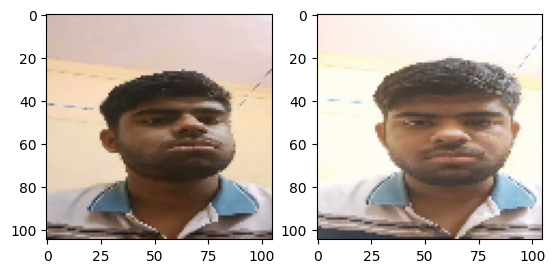

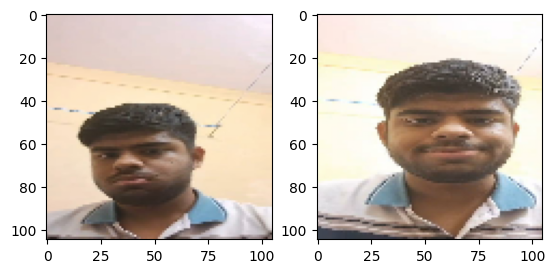

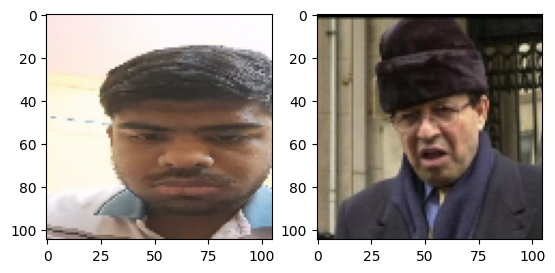

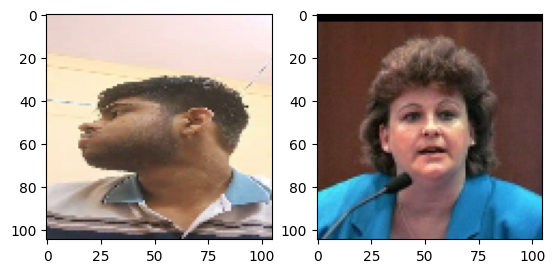

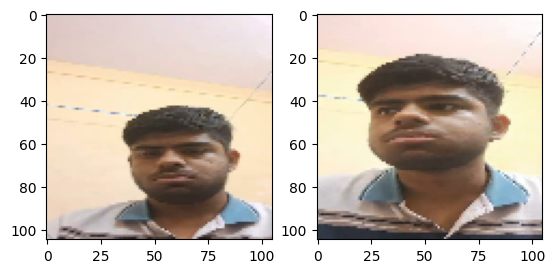

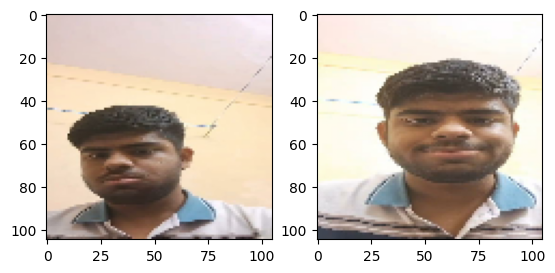

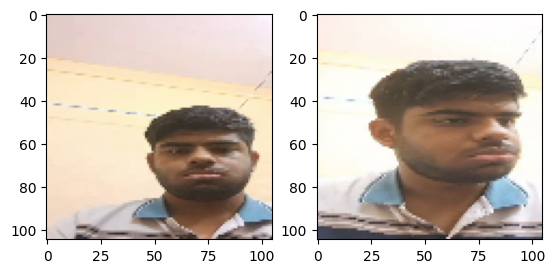

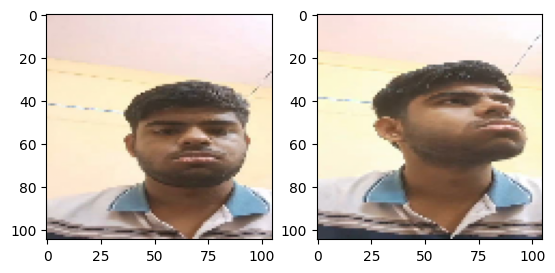

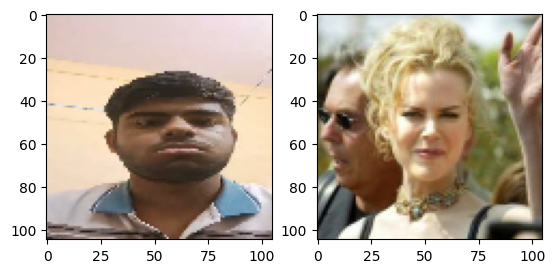

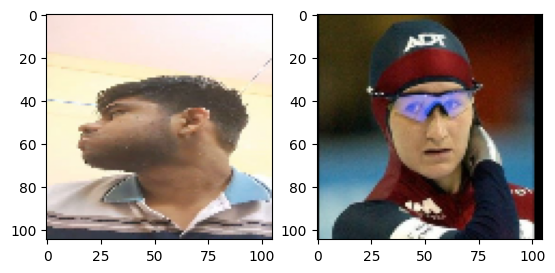

In [71]:
for index in range(10):
  # Set first subplot
  plt.subplot(1,2,1)
  plt.imshow(test_input[index])

  # Set second subplot
  plt.subplot(1,2,2)
  plt.imshow(test_val[index])

  # Renders clearly
  plt.show()

In [74]:
# Post processing the results
print([1 if prediction > 0.5 else 0 for prediction in y_hat])

[1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]


In [52]:
# Save weights
Siamese_Model.save('SiameseModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [60]:
# Reload model
model = tf.keras.models.load_model('SiameseModel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [61]:
# Moke predictions with re-loaded
model.predict([test_input, test_val])

1/1 [==============================] - 0s 214ms/step


array([[1.8029555e-09],
       [3.1604271e-15],
       [3.3036532e-10],
       [9.0066938e-14],
       [1.0000000e+00],
       [2.5184246e-15],
       [9.9999762e-01],
       [6.8758795e-13],
       [9.9852440e-13],
       [1.3711406e-12],
       [1.0000000e+00],
       [1.3049352e-11],
       [8.9924794e-07],
       [4.9463993e-14],
       [1.0000000e+00],
       [9.9999702e-01]], dtype=float32)